# **A deep learning approach for Deep Fake Video Detection**

# XceptionNet + Transformer

In [ ]:
# Mount the gogle drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# install face detector algorithm MTCNN (Multi Task Cascaded Convolutional Networks)
! pip install mtcnn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Video Classification with XceptionNet as feature extractor and Transformer as classifier

This is an approach to classify videos into different classes[REAL/FAKE] using two main components: XceptionNet as a feature extractor and a Transformer model as a classifier.

XceptionNet is a deep convolutional neural network (CNN) architecture that is often used for image-related tasks. In this context, it is employed as a feature extractor for video frames. The video frames are input to the XceptionNet, which extracts high-level visual features from each frame. The XceptionNet architecture is known for its ability to capture complex visual patterns and extract informative representations from images.

After extracting features from individual frames using XceptionNet, the features are then fed into a Transformer model. Transformers are popular models in natural language processing (NLP) tasks, but they can also be applied to sequence-based data like videos. In this case, the Transformer model is adapted for video classification. It takes the sequence of frame features as input and learns to model the temporal relationships and dependencies among the frames.

The Transformer model consists of multiple self-attention layers that enable it to attend to different parts of the video sequence and capture long-range dependencies effectively. The self-attention mechanism allows the model to weigh the importance of each frame's features based on their relevance to the video classification task. The final output of the Transformer model is a probability distribution over the different classes, indicating the predicted class or category for the input video.

By combining XceptionNet as a feature extractor and a Transformer model as a classifier, the approach leverages the powerful visual feature extraction capabilities of XceptionNet and the ability of Transformers to model temporal relationships in videos. This combination allows for accurate and robust video classification, enabling tasks such as action recognition, video summarization, or content-based video retrieval.

In [ ]:
# import necessary libraries

from tensorflow.keras import layers
from tensorflow import keras
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import imageio
import cv2
import os
from mtcnn import MTCNN
from google.colab.patches import cv2_imshow

In [ ]:
# define hyperparameters for training the model

MAX_SEQ_LENGTH = 50
NUM_FEATURES = 2048
IMG_SIZE = 224
EPOCHS = 30
accuracy_values = []

In [ ]:
# read and display the training dataset

train_df = pd.read_csv('/content/drive/Shareddrives/DATA255_Dataset/Dataset/Sample50/trainLabels (1).csv', dtype=str)
train_df.head()

,Filename,label
0,/content/drive/Shareddrives/DATA255_Dataset/Da...,REAL
1,/content/drive/Shareddrives/DATA255_Dataset/Da...,REAL
2,/content/drive/Shareddrives/DATA255_Dataset/Da...,REAL
3,/content/drive/Shareddrives/DATA255_Dataset/Da...,REAL
4,/content/drive/Shareddrives/DATA255_Dataset/Da...,REAL


In [ ]:
# read and display the test dataset

test_df = pd.read_csv('/content/drive/Shareddrives/DATA255_Dataset/Dataset/Sample50/testLabels (1).csv', dtype=str)
test_df.head()

,Filename,label
0,/content/drive/Shareddrives/DATA255_Dataset/Da...,REAL
1,/content/drive/Shareddrives/DATA255_Dataset/Da...,REAL
2,/content/drive/Shareddrives/DATA255_Dataset/Da...,REAL
3,/content/drive/Shareddrives/DATA255_Dataset/Da...,REAL
4,/content/drive/Shareddrives/DATA255_Dataset/Da...,REAL


# Feature Extraction using MTCNN

Feature extraction using MTCNN (Multi-task Cascaded Convolutional Networks) is a technique used to detect and extract facial features from images or video frames. MTCNN is a deep learning-based face detection algorithm that is specifically designed to handle face-related tasks, including face detection, facial landmark localization, and face alignment.

In [ ]:
# install MTCNN package
! pip install mtcnn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Create an instance of MTCNN
detector = MTCNN()

In [ ]:
# Sample code to play the video - not used

import cv2

def play_video(path):
  cap = cv2.VideoCapture(path)

  while cap.isOpened():
      ret, frame = cap.read()

      if not ret:
          break

      cv2_imshow(frame)
      
      # Exit if 'q' is pressed
      if cv2.waitKey(1) & 0xFF == ord('q'):
          break

  cap.release()
  cv2.destroyAllWindows()

In [ ]:
# function to load the vdieo and get the frames in an ideal case scenario
# the frames have alredy been extracted and saved to save time and computational power

def load_video(path, max_frames=5, resize=(IMG_SIZE, IMG_SIZE)):
    cap = cv2.VideoCapture(path)
    frames = []
    count = 0
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            result = detector.detect_faces(frame)
            #print(result)
            if len(result) > 0:
                x, y, w, h = result[0]['box']
                face = frame[y:y+h, x:x+w, :]
                face = cv2.resize(face, resize)
                face = face[:, :, [2, 1, 0]]
                frames.append(face)
                count += 1
            if count == max_frames:
                break
    finally:
        cap.release()

    return np.array(frames)

In [ ]:
# Extract features using XceptionNet architecture

def build_feature_extractor():
    feature_extractor = keras.applications.Xception(
        weights="imagenet",
        include_top=False,
        pooling="avg",
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
    )
    preprocess_input = keras.applications.xception.preprocess_input

    inputs = keras.Input((IMG_SIZE, IMG_SIZE, 3))
    preprocessed = preprocess_input(inputs)

    outputs = feature_extractor(preprocessed)
    return keras.Model(inputs, outputs, name="feature_extractor")

In [ ]:
# call the feature extractor function
feature_extractor = build_feature_extractor()

In [ ]:
# Label preprocessing with StringLookup.
# The code creates a StringLookup layer to map labels to integer indices based on the unique 
# labels found in the "label" column of the train_df DataFrame. 
# It then prints the resulting vocabulary of labels.

label_processor = keras.layers.StringLookup(
    num_oov_indices=0, vocabulary=np.unique(train_df["label"]), mask_token=None
)
print(label_processor.get_vocabulary())

['FAKE', 'REAL']


In [ ]:
# function to call videos and extract features using the functions which are defined above

def prepare_all_videos(df, root_dir):
    print(root_dir) 
    num_samples = len(df)
    video_paths = df["Filename"].values.tolist()
    labels = df["label"].values
    labels = label_processor(labels[..., None]).numpy()

    # `frame_features` are what we will feed to our sequence model.
    frame_features = np.zeros(
        shape=(num_samples, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
    )
    # For each video.
    for idx, path in enumerate(video_paths):
      print(idx)
      print(path)
      # Gather all its frames and add a batch dimension.
      frames = load_video(path)


      # #Pad shorter videos.
      # if len(frames) < MAX_SEQ_LENGTH:
      #     diff = MAX_SEQ_LENGTH - len(frames)
      #     padding = np.zeros((diff, IMG_SIZE, IMG_SIZE, 3))
      #     frames = np.concatenate(frames, padding)

      # frames = frames[None, ...]

      # Initialize placeholder to store the features of the current video.
      temp_frame_features = np.zeros(
          shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
      )

      # Extract features from the frames of the current video.
      for i, batch in enumerate(frames):
          video_length = batch.shape[0]
          length = min(MAX_SEQ_LENGTH, video_length)
          for j in range(length):
              if np.mean(batch[j, :]) > 0.0:
                  temp_frame_features[i, j, :] = feature_extractor.predict(
                      batch[None, j, :])

              else:
                  temp_frame_features[i, j, :] = 0.0

      frame_features[idx,] = temp_frame_features.squeeze()
      # Save the frame_features and frame_masks arrays
      #np.save(os.path.join(root_dir, 'frame_features.npy'), frame_features)
      #np.save(os.path.join(root_dir, 'frame_masks.npy'), frame_masks)
      #np.save(os.path.join(root_dir, 'labels.npy'), labels)

    #return frame_features, labels

## Load the saved data

In [ ]:
# The features are extracted and stored in gdrive.
# We can directly access the data rather than doing on the fly

# Link to stored train data: https://drive.google.com/file/d/1h9WgjrPCmaDIhZN8XOxzAyOg89FwR8rO/view?usp=share_link

# To import the stored train data:

# Load the saved data using numpy's load function.
loaded_train_data = np.load("/content/drive/Shareddrives/DATA255_Dataset/Code/prepared_train_data.npz")

# Retrieve the individual arrays from the loaded data.
frame_features = loaded_train_data["frame_features"]
train_labels = loaded_train_data["labels"]
print(f'Train labels shape :{train_labels.shape}')

# Reconstruct the prepared_data tuple.
train_data = (frame_features)
print(f'Train data shape {frame_features.shape}')


Train labels shape :(38, 1)
Train data shape (38, 50, 2048)


In [ ]:
# To import the stored test data:

# Link to stored data: https://drive.google.com/file/d/1h9WgjrPCmaDIhZN8XOxzAyOg89FwR8rO/view?usp=share_link

# Load the saved data using numpy's load function.
loaded_test_data = np.load("/content/drive/Shareddrives/DATA255_Dataset/Code/prepared_test_data.npz")

# Retrieve the individual arrays from the loaded data.
frame_features = loaded_test_data["frame_features"]
test_labels = loaded_test_data["labels"]
print(f'Test labels shape :{test_labels.shape}')

# Reconstruct the prepared_data tuple.
test_data = (frame_features)
print(f'Test data shape {frame_features.shape}')


Test labels shape :(10, 1)
Test data shape (10, 50, 2048)


In [ ]:
# Frame features in train and test
print(f"Frame features in train set: {train_data.shape}")
print(f"Frame features in test set: {test_data.shape}")

Frame features in train set: (38, 50, 2048)
Frame features in test set: (10, 50, 2048)


## Build transformer model

In [ ]:
# Build transformer based model 

class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=output_dim
        )
        self.sequence_length = sequence_length
        self.output_dim = output_dim

    def call(self, inputs):
        # The inputs are of shape: `(batch_size, frames, num_features)`
        length = tf.shape(inputs)[1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_positions = self.position_embeddings(positions)
        return inputs + embedded_positions

    def compute_mask(self, inputs, mask=None):
        mask = tf.reduce_any(tf.cast(inputs, "bool"), axis=-1)
        return mask

In [ ]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.3
        )
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation=tf.nn.gelu), layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()

    def call(self, inputs, mask=None):
        if mask is not None:
            mask = mask[:, tf.newaxis, :]

        attention_output = self.attention(inputs, inputs, attention_mask=mask)
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)

# Model Development

**Without K-fold validation**

In [ ]:
# function to concatenate all layers and form the model

def get_compiled_model():
    sequence_length = MAX_SEQ_LENGTH #50
    embed_dim = NUM_FEATURES #2048
    dense_dim = 4
    num_heads = 1
    classes = len(label_processor.get_vocabulary())

    inputs = keras.Input(shape=(50, 2048)) #None, None
    x = PositionalEmbedding(
        sequence_length, embed_dim, name="frame_position_embedding"
    )(inputs)
    x = TransformerEncoder(embed_dim, dense_dim, num_heads, name="transformer_layer")(x)
    x = layers.GlobalMaxPooling1D()(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(classes, activation="softmax")(x)
    # print(inputs.shape)
    # print(outputs.shape)
    model = keras.Model(inputs, outputs)

    model.compile(
        optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
    )
    return model

In [ ]:
# Function to train the model without K-Fold

def run_experiment():
    filepath = "/tmp/video_classifier"
    checkpoint = keras.callbacks.ModelCheckpoint(
        filepath, save_weights_only=True, save_best_only=True, verbose=1
    )

    model = get_compiled_model()
    history = model.fit(
        train_data,
        train_labels,
        validation_split=0.15,
        epochs=EPOCHS,
        callbacks=[checkpoint],
    )

    model.load_weights(filepath)
    _, accuracy = model.evaluate(test_data, test_labels)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

    # Accuracy curve
    import matplotlib.pyplot as plt
    plt.plot(history.history["accuracy"], label = 'Training accuracy')
    plt.plot(history.history["val_accuracy"], label='Validation accuracy')
    plt.title('Model Training and Validation Accuracy')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(["train", "test"], loc="upper left")
    plt.show()

    # Loss curve
    plt.plot(history.history["loss"])
    plt.plot(history.history["val_loss"])
    plt.title('Model Training and Validation Loss')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(["train", "test"], loc="upper left")
    plt.show()

    return model

Epoch 1/30
1/1 [==============================] - ETA: 0s - loss: 2.1174 - accuracy: 0.5938
Epoch 1: val_loss improved from inf to 45.56166, saving model to /tmp/video_classifier
1/1 [==============================] - 8s 8s/step - loss: 2.1174 - accuracy: 0.5938 - val_loss: 45.5617 - val_accuracy: 0.0000e+00
Epoch 2/30
1/1 [==============================] - ETA: 0s - loss: 16.7934 - accuracy: 0.5312
Epoch 2: val_loss improved from 45.56166 to 0.00000, saving model to /tmp/video_classifier
1/1 [==============================] - 5s 5s/step - loss: 16.7934 - accuracy: 0.5312 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3/30
1/1 [==============================] - ETA: 0s - loss: 13.1432 - accuracy: 0.4688
Epoch 3: val_loss did not improve from 0.00000
1/1 [==============================] - 4s 4s/step - loss: 13.1432 - accuracy: 0.4688 - val_loss: 2.8451e-05 - val_accuracy: 1.0000
Epoch 4/30
1/1 [==============================] - ETA: 0s - loss: 4.4065 - accuracy: 0.4688
Epoch 4: val

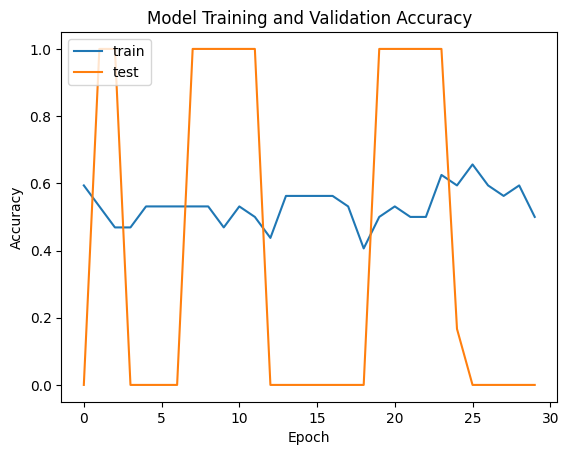

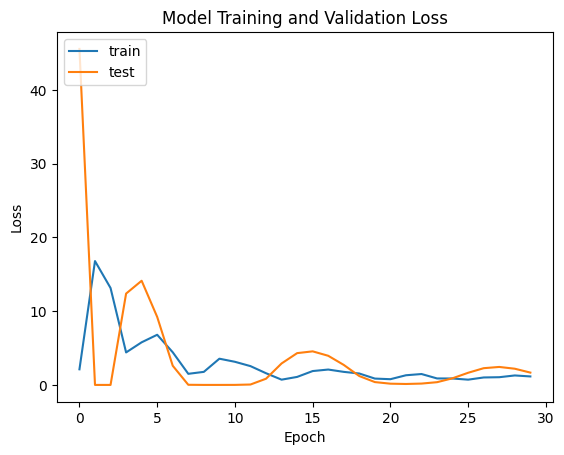

In [ ]:
# model training and inference without K-Fold cross validation

trained_model = run_experiment()

From the above graphs, we can observe that the training accuracy almost remains consistent, however, there is a lot of fluctuation in the testing accuracy. Looks like the model is overfitting. We need measures to tackle this problem and hence one way we could think of using k-fold cross-validation and other ways are to experiment with learning rate /optimiser, run for multiple epochs and observe the performance.

When it comes to loss curve, both test and train loss is consistent and minimal.

In [ ]:
# describing the summary of the model.
model = get_compiled_model()
model.summary()

Model: "model_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_37 (InputLayer)       [(None, 50, 2048)]        0         
                                                                 
 frame_position_embedding (P  (None, 50, 2048)         102400    
 ositionalEmbedding)                                             
                                                                 
 transformer_layer (Transfor  (None, 50, 2048)         16812036  
 merEncoder)                                                     
                                                                 
 global_max_pooling1d_23 (Gl  (None, 2048)             0         
 obalMaxPooling1D)                                               
                                                                 
 dropout_23 (Dropout)        (None, 2048)              0         
                                                          

## Train model with k-fold cross validation

In [ ]:
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

# Utility for running experiments.
def run_experiment():
    # Initialize arrays to store accuracy values from each fold.
    accuracies = []
    # Initialize arrays to store accuracy values from each fold.
    fold_train_loss = []
    fold_val_loss = []
    fold_train_acc = []
    fold_val_acc = []

    fold_no = 1
    
    # Initialize KFold cross-validation.
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    
    # Initialize the model checkpoint callback.
    filepath = "/tmp/video_classifier"
    checkpoint = keras.callbacks.ModelCheckpoint(
        filepath, save_weights_only=True, save_best_only=True, verbose=1
    )

    # Loop over the folds.
    for train_idx, val_idx in kfold.split(train_data):
        print(f"Fold {fold_no}...")
        fold_no += 1
        
        # Split the training data into training and validation sets.
        x_train = [train_data[train_idx]]
        y_train = train_labels[train_idx]
        x_val = [train_data[val_idx]]
        y_val = train_labels[val_idx]

        # Create the model and compile it.
        seq_model = get_compiled_model()
        # seq_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

        # Train the model on the current fold.
        history = seq_model.fit(
            x_train,
            y_train,
            validation_data=(x_val, y_val),
            epochs=EPOCHS,
            callbacks=[checkpoint],
        )

        # Append the training and validation loss and accuracy to the respective lists.
        fold_train_loss.append(history.history['loss'])
        fold_val_loss.append(history.history['val_loss'])
        fold_train_acc.append(history.history['accuracy'])
        fold_val_acc.append(history.history['val_accuracy'])

        # Evaluate the model on the test set and store the accuracy.
        seq_model.load_weights(filepath)
        _, accuracy = seq_model.evaluate(test_data, test_labels)
        accuracies.append(accuracy)
        print(f"Fold {fold_no - 1} test accuracy: {round(accuracy * 100, 2)}%")

    # Convert the lists to numpy arrays.
    fold_train_loss = np.array(fold_train_loss)
    fold_val_loss = np.array(fold_val_loss)
    fold_train_acc = np.array(fold_train_acc)
    fold_val_acc = np.array(fold_val_acc)

    # Compute the average values across the folds for each epoch.
    avg_train_loss = np.mean(fold_train_loss, axis=0)
    avg_val_loss = np.mean(fold_val_loss, axis=0)
    avg_train_acc = np.mean(fold_train_acc, axis=0)
    avg_val_acc = np.mean(fold_val_acc, axis=0)
    
    # Calculate mean and standard deviation of accuracies across all folds.
    mean_accuracy = np.mean(accuracies)
    std_dev_accuracy = np.std(accuracies)

    print(f"Mean test accuracy: {round(mean_accuracy * 100, 2)}% +/- {round(std_dev_accuracy * 100, 2)}%")

    epochs = range(1, len(avg_train_loss) + 1)

    # Loss curve
    # plt.figure()
    plt.figure(figsize=(14,5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, avg_train_loss, 'b', label='Average Training Loss')
    plt.plot(epochs, avg_val_loss, 'r', label='Average Validation Loss')
    plt.title('Average Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy curve
    # plt.figure()
    plt.subplot(1, 2, 2)
    plt.plot(epochs, avg_train_acc, color='green', label='Average Training Accuracy')
    plt.plot(epochs, avg_val_acc,  color='orange', label='Average Validation Accuracy')
    plt.title('Average Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Display the plots
    plt.show()

    return seq_model

Fold 1...
Epoch 1/30
1/1 [==============================] - ETA: 0s - loss: 1.4254 - accuracy: 0.4667
Epoch 1: val_loss improved from inf to 18.60544, saving model to /tmp/video_classifier
1/1 [==============================] - 9s 9s/step - loss: 1.4254 - accuracy: 0.4667 - val_loss: 18.6054 - val_accuracy: 0.3750
Epoch 2/30
1/1 [==============================] - ETA: 0s - loss: 11.7118 - accuracy: 0.4667
Epoch 2: val_loss improved from 18.60544 to 15.66500, saving model to /tmp/video_classifier
1/1 [==============================] - 5s 5s/step - loss: 11.7118 - accuracy: 0.4667 - val_loss: 15.6650 - val_accuracy: 0.6250
Epoch 3/30
1/1 [==============================] - ETA: 0s - loss: 16.3488 - accuracy: 0.5333
Epoch 3: val_loss improved from 15.66500 to 11.16324, saving model to /tmp/video_classifier
1/1 [==============================] - 5s 5s/step - loss: 16.3488 - accuracy: 0.5333 - val_loss: 11.1632 - val_accuracy: 0.6250
Epoch 4/30
1/1 [==============================] - ETA: 0s 

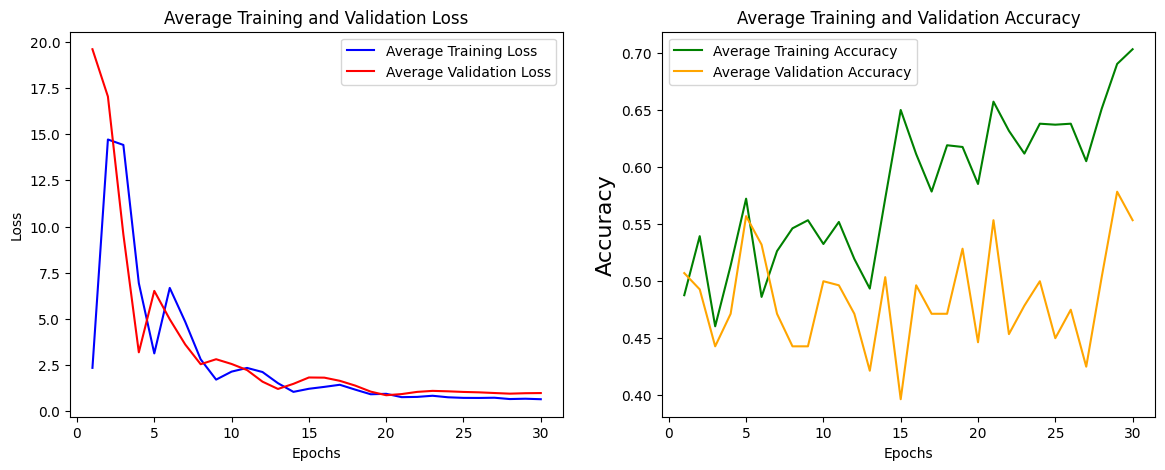

In [ ]:
# train the model with k-fold cross validation
trained_model = run_experiment()

Loss curve: The average training and validation loss decreases over time which is a good sign 

Accuracy Curve: The accuracy increases and decreases with a final up until 25 epochs and above that it consistently increases until 30 epochs. 

When evaluated on the test data, the model gives 74% +/- 4.9% which is a decent accuracy with 4.9% variation. It could be improved by increasing the video data, considering more number of frames and also running for more epochs

In [ ]:
# To validate the test video

def prepare_single_video(frames):
    frame_features = np.zeros(shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32")

    #Pad shorter videos.
    # if len(frames) < MAX_SEQ_LENGTH:
    #     diff = MAX_SEQ_LENGTH - len(frames)
    #     padding = np.zeros((diff, IMG_SIZE, IMG_SIZE, 3))
    #     frames = np.concatenate(frames, padding)

    frames = frames[None, ...]

    # Extract features from the frames of the current video.
    for i, batch in enumerate(frames):
        video_length = batch.shape[0]
        length = min(MAX_SEQ_LENGTH, video_length)
        for j in range(length):
            if np.mean(batch[j, :]) > 0.0:
                frame_features[i, j, :] = feature_extractor.predict(batch[None, j, :])
            else:
                frame_features[i, j, :] = 0.0

    return frame_features


def predict_action(path):
    class_vocab = label_processor.get_vocabulary()

    #frames = load_video(os.path.join("test", path))
    frames = load_video(path)
    frame_features = prepare_single_video(frames)
    probabilities = trained_model.predict(frame_features)[0]

    for i in np.argsort(probabilities)[::-1]:
        print(f"  {class_vocab[i]}: {probabilities[i] * 100:5.2f}%")
    return frames

In [ ]:
# convert the 'Filename' column in the datframe to a list
test_df["Filename"].values.tolist()

['/content/drive/Shareddrives/DATA255_Dataset/Dataset/Sample50/Videos/prdrkaxeob.mp4',
 '/content/drive/Shareddrives/DATA255_Dataset/Dataset/Sample50/Videos/pqdeutauqc.mp4',
 '/content/drive/Shareddrives/DATA255_Dataset/Dataset/Sample50/Videos/xjzkfqddyk.mp4',
 '/content/drive/Shareddrives/DATA255_Dataset/Dataset/Sample50/Videos/fufcmupzen.mp4',
 '/content/drive/Shareddrives/DATA255_Dataset/Dataset/Sample50/Videos/lokzwdldxp.mp4',
 '/content/drive/Shareddrives/DATA255_Dataset/Dataset/Sample50/Videos/hplxtssgnz.mp4',
 '/content/drive/Shareddrives/DATA255_Dataset/Dataset/Sample50/Videos/owxbbpjpch.mp4',
 '/content/drive/Shareddrives/DATA255_Dataset/Dataset/Sample50/Videos/htorvhbcae.mp4',
 '/content/drive/Shareddrives/DATA255_Dataset/Dataset/Sample50/Videos/fckxaqjbxk.mp4',
 '/content/drive/Shareddrives/DATA255_Dataset/Dataset/Sample50/Videos/sphirandia.mp4']

In [ ]:
# Testing for video lokzwdldxp.mp4 that is REAL

test_video = '/content/drive/Shareddrives/DATA255_Dataset/Dataset/Sample50/Videos/lokzwdldxp.mp4'
print(f"Test video path: {test_video}")
test_frames = predict_action(test_video)

Test video path: /content/drive/Shareddrives/DATA255_Dataset/Dataset/Sample50/Videos/lokzwdldxp.mp4
1/1 [==============================] - 0s 356ms/step
  REAL: 76.33%
  FAKE: 23.67%


In [ ]:
# Testing for video fufcmupzen.mp4 that is FAKE

test_video = '/content/drive/Shareddrives/DATA255_Dataset/Dataset/Sample50/Videos/fufcmupzen.mp4'
print(f"Test video path: {test_video}")
test_frames = predict_action(test_video)

Test video path: /content/drive/Shareddrives/DATA255_Dataset/Dataset/Sample50/Videos/fufcmupzen.mp4
1/1 [==============================] - 0s 85ms/step
  REAL: 68.47%
  FAKE: 31.53%
